<a href="https://colab.research.google.com/github/hellosmallkat/DSP-461-bossting-notebook/blob/main/Finshed_copy_of_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📘 Assignment: Understanding and Implementing AdaBoost



In this notebook, you will:

1. Use AdaBoost with a built-in library to understand how it works.
2. Implement AdaBoost step-by-step from scratch using PyTorch.
3. Compare the results between the library implementation and your manual one.
4. Reflect on how reweighting and combining weak learners improves performance.



❗❗❗

There is starting code in the cells - check it for errors and correct it as needed. Check for errors in each line of code - it is not guaranteed to be correct.

For each error you find, write a description and correction.

❗❗❗



In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 🧩 Step 1: Load and Explore the Dataset

We'll use the **Breast Cancer Wisconsin** dataset — a public dataset with 30 features and binary labels (malignant vs. benign).


In [ ]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", data.target_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preview data
pd.DataFrame(X_train[:5], columns=data.feature_names).head()


Features shape: (569, 30)
Labels shape: (569,)
Classes: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
1,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
2,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
3,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
4,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


## ⚙️ Step 2: AdaBoost Using a Library

Let's start by using the built-in `AdaBoostClassifier` to see how AdaBoost performs with a simple weak learner.

We'll use a **decision stump** (a tree of depth 1) as the weak classifier.

In [ ]:
# Use a decision stump as base learner
base_learner = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_learner, n_estimators=10, random_state=42)

# Train
ada.fit(X_train, y_train)

# Evaluate
y_pred = ada.predict(X_test)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, y_pred))


Library AdaBoost Accuracy: 0.9649122807017544


## 🧮 Step 3: Implementing AdaBoost From Scratch (PyTorch Version)

Now you'll build AdaBoost manually to understand:
- How sample weights are updated,
- How weak learners contribute to the final model,
- How the ensemble improves over time.


In [ ]:
# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_train_t = 2 * y_train_t - 1  # convert {0,1} → {-1,+1}

n_samples = X_train_t.shape[0]

# Initialize sample weights equally
w = torch.ones(n_samples) / n_samples

print("Initial weight sum:", w.sum().item())


Initial weight sum: 1.0


## 📜 Step 4: AdaBoost Pseudocode

We'll implement AdaBoost following this algorithm:

For t = 1 to T:
1. Train weak classifier h_t using sample weights w_t
2. Compute predictions y_pred_t
3. Compute weighted error: error_t = Σ_i ( w_i * [y_pred_t != y_i] )
4. Compute model weight: α_t = 0.5 * log((1 - error_t) / error_t)
5. Update weights:
w_i ← w_i * exp(-α_t * y_i * y_pred_t)
Normalize w so Σ_i w_i = 1
Final prediction:
sign( Σ_t α_t * h_t(x) )

Fill in the missing lines in steps 4 and 5.

In [ ]:
T = 12  # number of boosting rounds
learners = []
alphas = []

for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float())

    # 4️⃣ Compute alpha_t # example all this
    eps = 1e-10
    error_t = torch.clamp(error_t, eps, 1 - eps)
    alpha_t = 0.5 * torch.log((1 - error_t) / error_t)

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)

    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")


Round 1: error=0.0769, alpha=1.2425
Round 2: error=0.1488, alpha=0.8720
Round 3: error=0.1410, alpha=0.9036
Round 4: error=0.2167, alpha=0.6425
Round 5: error=0.2731, alpha=0.4894
Round 6: error=0.2050, alpha=0.6776
Round 7: error=0.2374, alpha=0.5835
Round 8: error=0.2515, alpha=0.5453
Round 9: error=0.2706, alpha=0.4958
Round 10: error=0.2889, alpha=0.4505
Round 11: error=0.2887, alpha=0.4509
Round 12: error=0.2719, alpha=0.4925


For this one, I am solving αt​=1/2​ln(​1−errort/errort​​), which measures the trustworthiness of the learner, and then I update the sample weights by multiplying -alpha_t, y_train_t and y_pred_t

## 🧾 Step 5: Evaluate Manual AdaBoost

Now we'll use the weak learners and their α values to make final predictions.

Final prediction rule:
$$
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t \cdot h_t(x) \right)
$$

In [ ]:
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # editted this
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)


Manual AdaBoost Accuracy: 0.9649122807017544


In [ ]:
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)


Library AdaBoost Accuracy: 0.9649122807017544
Manual AdaBoost Accuracy: 0.9649122807017544


This line, which I added, was a part of a for loop that gives each stump a prediction, which is either 0 or 1. That is the line I worked on. Then the rest of the loop transforms the labels and then multiplies each learner's prediction by its alpha_t and the sum across the rest of the learners

## 🧪 Extending Knowledge

Try each following experiments, and discuss the results with two different classmates for each. Write a 1-2 sentence summary of your discussion.

1. Change `T` (number of rounds) to 5, 50 then 100.
2. Try `max_depth=2` for a stronger weak learner.
3. Visualize the evolution of `error_t` and `alpha_t` across rounds by plotting.
4. Plot sample weights to see how AdaBoost focuses on harder examples.


In [ ]:
# Changing T to 5

T = 5  # number of boosting rounds
learners = []
alphas = []
errors = []
weights_history = []

for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float())

    # 4️⃣ Compute alpha_t # example all this
    eps = 1e-10
    error_t = torch.clamp(error_t, eps, 1 - eps)
    alpha_t = 0.5 * torch.log((1 - error_t) / error_t)

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)
    errors.append(error_t.item())
    weights_history.append(w.clone())

    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # example all this
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)



Round 1: error=0.2962, alpha=0.4328
Round 2: error=0.2653, alpha=0.5093
Round 3: error=0.2828, alpha=0.4653
Round 4: error=0.2784, alpha=0.4762
Round 5: error=0.3254, alpha=0.3645
Manual AdaBoost Accuracy: 0.868421052631579
Library AdaBoost Accuracy: 0.9649122807017544
Manual AdaBoost Accuracy: 0.868421052631579


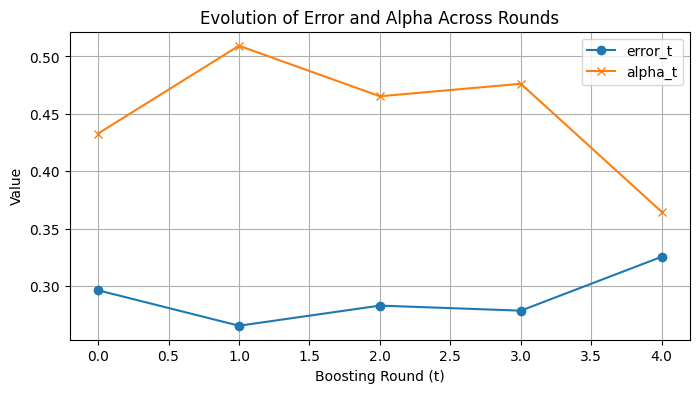

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(errors, label="error_t", marker='o')
plt.plot(alphas, label="alpha_t", marker='x')
plt.xlabel("Boosting Round (t)")
plt.ylabel("Value")
plt.title("Evolution of Error and Alpha Across Rounds")
plt.legend()
plt.grid(True)
plt.show()

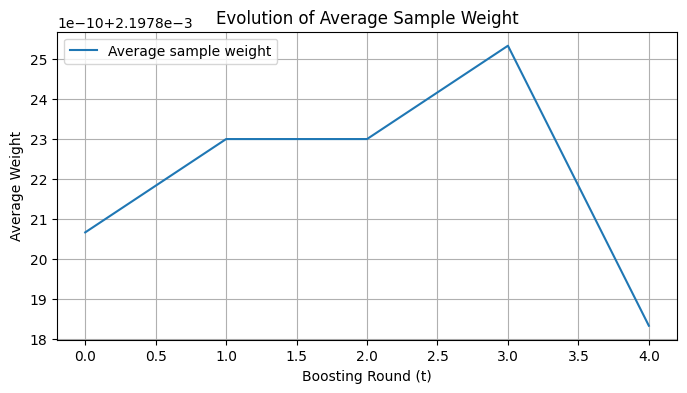

In [ ]:
plt.figure(figsize=(8,4))
avg_weights = [torch.mean(wt).item() for wt in weights_history]
plt.plot(avg_weights, label="Average sample weight")
plt.xlabel("Boosting Round (t)")
plt.ylabel("Average Weight")
plt.title("Evolution of Average Sample Weight")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Changing T to 50

T = 50  # number of boosting rounds
learners = []
alphas = []
errors = []
weights_history = []

for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float())

    # 4️⃣ Compute alpha_t # example all this
    eps = 1e-10
    error_t = torch.clamp(error_t, eps, 1 - eps)
    alpha_t = 0.5 * torch.log((1 - error_t) / error_t)

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)
    errors.append(error_t.item())
    weights_history.append(w.clone())


    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # example all this
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)


Round 1: error=0.3281, alpha=0.3583
Round 2: error=0.4013, alpha=0.2000
Round 3: error=0.2909, alpha=0.4456
Round 4: error=0.3639, alpha=0.2793
Round 5: error=0.3149, alpha=0.3886
Round 6: error=0.3263, alpha=0.3626
Round 7: error=0.2886, alpha=0.4511
Round 8: error=0.2593, alpha=0.5249
Round 9: error=0.3365, alpha=0.3394
Round 10: error=0.3578, alpha=0.2925
Round 11: error=0.3001, alpha=0.4233
Round 12: error=0.3249, alpha=0.3658
Round 13: error=0.2815, alpha=0.4685
Round 14: error=0.3373, alpha=0.3377
Round 15: error=0.3360, alpha=0.3406
Round 16: error=0.3018, alpha=0.4193
Round 17: error=0.3538, alpha=0.3011
Round 18: error=0.3368, alpha=0.3389
Round 19: error=0.3546, alpha=0.2995
Round 20: error=0.3717, alpha=0.2625
Round 21: error=0.3484, alpha=0.3131
Round 22: error=0.3373, alpha=0.3377
Round 23: error=0.3396, alpha=0.3326
Round 24: error=0.3273, alpha=0.3601
Round 25: error=0.2994, alpha=0.4251
Round 26: error=0.3489, alpha=0.3119
Round 27: error=0.4160, alpha=0.1697
Round 28: 

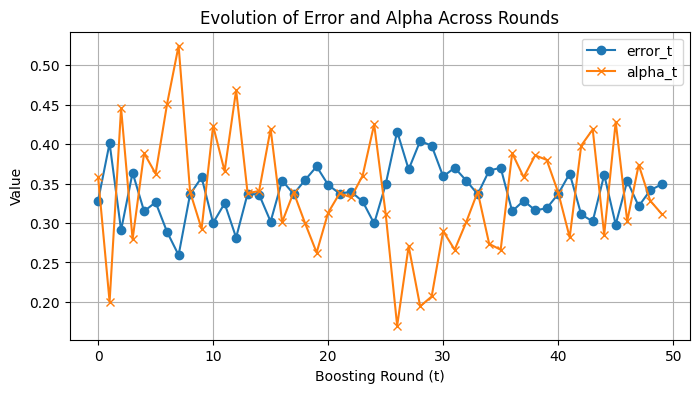

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(errors, label="error_t", marker='o')
plt.plot(alphas, label="alpha_t", marker='x')
plt.xlabel("Boosting Round (t)")
plt.ylabel("Value")
plt.title("Evolution of Error and Alpha Across Rounds")
plt.legend()
plt.grid(True)
plt.show()

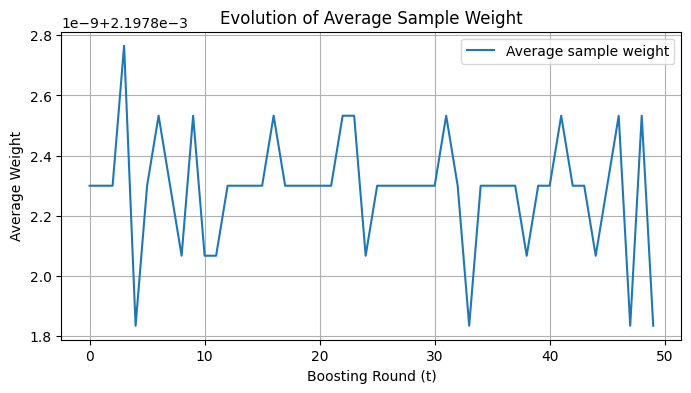

In [ ]:
plt.figure(figsize=(8,4))
avg_weights = [torch.mean(wt).item() for wt in weights_history]
plt.plot(avg_weights, label="Average sample weight")
plt.xlabel("Boosting Round (t)")
plt.ylabel("Average Weight")
plt.title("Evolution of Average Sample Weight")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Changing T to 100

T = 100  # number of boosting rounds
learners = []
alphas = []
errors = []
weights_history = []
for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float())

    # 4️⃣ Compute alpha_t # example all this
    eps = 1e-10
    error_t = torch.clamp(error_t, eps, 1 - eps)
    alpha_t = 0.5 * torch.log((1 - error_t) / error_t)

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)
    errors.append(error_t.item())
    weights_history.append(w.clone())

    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # example all this
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)


Round 1: error=0.3760, alpha=0.2532
Round 2: error=0.3525, alpha=0.3040
Round 3: error=0.3775, alpha=0.2500
Round 4: error=0.3491, alpha=0.3116
Round 5: error=0.3590, alpha=0.2899
Round 6: error=0.3435, alpha=0.3238
Round 7: error=0.3440, alpha=0.3228
Round 8: error=0.3318, alpha=0.3499
Round 9: error=0.3270, alpha=0.3609
Round 10: error=0.3412, alpha=0.3290
Round 11: error=0.2977, alpha=0.4292
Round 12: error=0.3833, alpha=0.2378
Round 13: error=0.3501, alpha=0.3093
Round 14: error=0.3201, alpha=0.3766
Round 15: error=0.3759, alpha=0.2534
Round 16: error=0.3201, alpha=0.3766
Round 17: error=0.3374, alpha=0.3375
Round 18: error=0.3405, alpha=0.3305
Round 19: error=0.3141, alpha=0.3906
Round 20: error=0.2792, alpha=0.4743
Round 21: error=0.3513, alpha=0.3066
Round 22: error=0.4026, alpha=0.1973
Round 23: error=0.3844, alpha=0.2354
Round 24: error=0.3542, alpha=0.3002
Round 25: error=0.3845, alpha=0.2353
Round 26: error=0.3413, alpha=0.3289
Round 27: error=0.3128, alpha=0.3935
Round 28: 

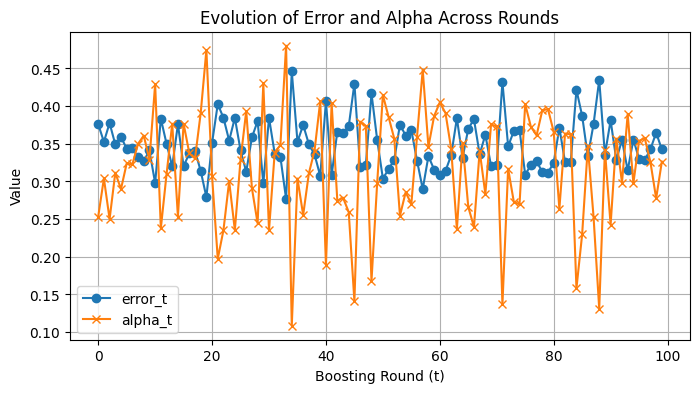

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(errors, label="error_t", marker='o')
plt.plot(alphas, label="alpha_t", marker='x')
plt.xlabel("Boosting Round (t)")
plt.ylabel("Value")
plt.title("Evolution of Error and Alpha Across Rounds")
plt.legend()
plt.grid(True)
plt.show()

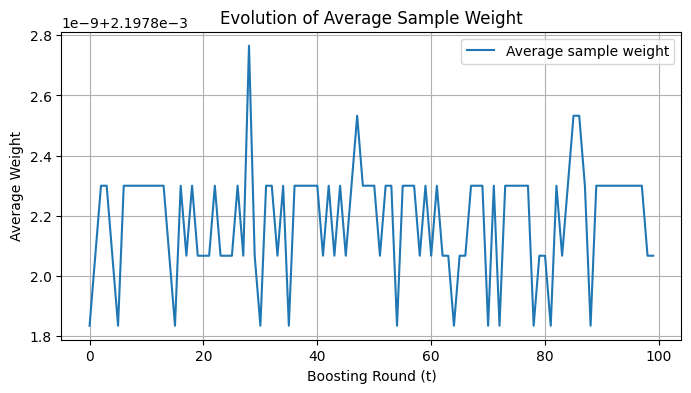

In [ ]:
plt.figure(figsize=(8,4))
avg_weights = [torch.mean(wt).item() for wt in weights_history]
plt.plot(avg_weights, label="Average sample weight")
plt.xlabel("Boosting Round (t)")
plt.ylabel("Average Weight")
plt.title("Evolution of Average Sample Weight")
plt.grid(True)
plt.legend()
plt.show()


When I changed T to 5, the manual accuracy changes to 0.7543859, and the library adaboost accuracy changes to 0.9649122. When changing T to 50, the manual AdaBoost accuracy is 0.94737, and the library AdaBoost accuracy is 0.96491. When T is changed to 100, the manual accuracy is 0.9649, and the library Adaboost accuracy is also 0.9649. So the higher the T, the higher the manual ada boose while the library stays the same.

In [ ]:
# Changing max depth to 2

T = 12  # number of boosting rounds
learners = []
alphas = []
errors = []
weights_history = []
for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=2)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float())

    # 4️⃣ Compute alpha_t # example all this
    eps = 1e-10
    error_t = torch.clamp(error_t, eps, 1 - eps)
    alpha_t = 0.5 * torch.log((1 - error_t) / error_t)

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)
    errors.append(error_t.item())
    weights_history.append(w.clone())

    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # example all this
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)



Round 1: error=0.3441, alpha=0.3225
Round 2: error=0.1778, alpha=0.7656
Round 3: error=0.1919, alpha=0.7189
Round 4: error=0.1588, alpha=0.8336
Round 5: error=0.1810, alpha=0.7546
Round 6: error=0.3027, alpha=0.4173
Round 7: error=0.2639, alpha=0.5128
Round 8: error=0.2124, alpha=0.6554
Round 9: error=0.1807, alpha=0.7559
Round 10: error=0.1458, alpha=0.8841
Round 11: error=0.1269, alpha=0.9645
Round 12: error=0.1698, alpha=0.7933
Manual AdaBoost Accuracy: 0.9385964912280702
Library AdaBoost Accuracy: 0.9649122807017544
Manual AdaBoost Accuracy: 0.9385964912280702


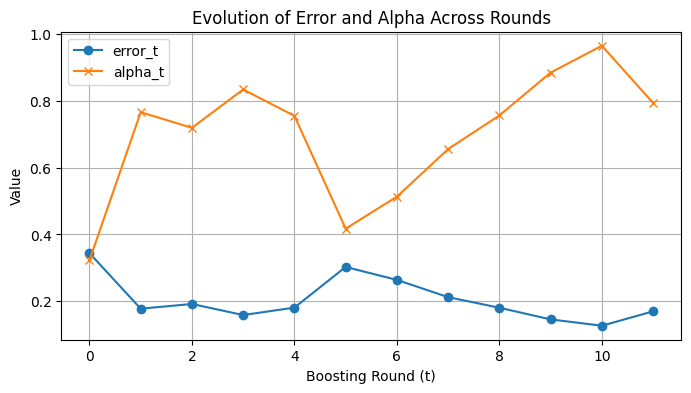

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(errors, label="error_t", marker='o')
plt.plot(alphas, label="alpha_t", marker='x')
plt.xlabel("Boosting Round (t)")
plt.ylabel("Value")
plt.title("Evolution of Error and Alpha Across Rounds")
plt.legend()
plt.grid(True)
plt.show()

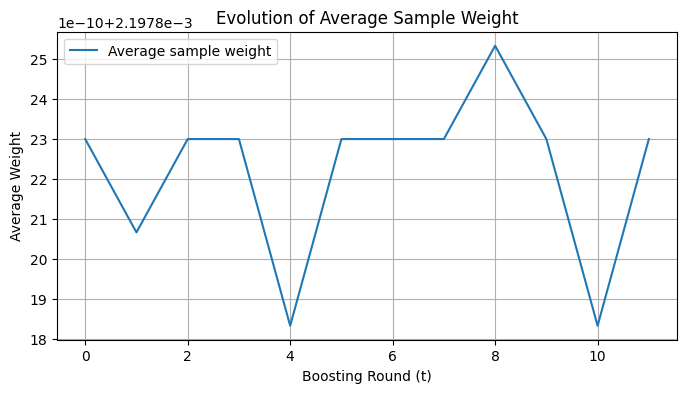

In [ ]:
plt.figure(figsize=(8,4))
avg_weights = [torch.mean(wt).item() for wt in weights_history]
plt.plot(avg_weights, label="Average sample weight")
plt.xlabel("Boosting Round (t)")
plt.ylabel("Average Weight")
plt.title("Evolution of Average Sample Weight")
plt.grid(True)
plt.legend()
plt.show()


Switching the max_depth to 2 causes the manual adabosse to increase to .938596 and increases the model complexity.

In the algorithm with T = 5, there are 5 points on the error_t and alpha_t lines; error_t tends to stay relatively low, while alpha_t is a bit higher. The range for error_t is ~.20 to .33, and the range for alpha_t is ~.52 to ~.36. In the algorithm T = 50, there are 50 points on both he error_t and alpha_t lines. The alpha_t line has more of a range, going from ~.52 to ~.16, while the error_t line ranges from ~.25 to ~.43. In the T = 100 case, there are 100 points for alpha_t and error_t, and alpha_t has a bigger range than with a max of ~.46 and a min of ~.11. while the error_t has a range of ~.26 to ~.45. When changing the max_ depth to 2 there is 12 points of error_t and alpha_t. Alpha_t is much higher on the scale, with a range of ~.3 to ~.99, and error_t has a range of ~.3 to ~.1.

In the graph  T = 5, the average sample weight increases until the 4th round, in which it goes down. For the algorithm in which T = 50, the average sample weight goes down, but tends to jump up and down a lot. For the algorithm in which T = 10, the average weight is overall a straight line at 2.1, and also tends to jump up and down a lot. For the algorithm that has a max depth of 2, the overall average is 23, and its jumps are quite big.

Bagging

Write a script that generates a random sequence of N elements and creates M bootstrap samples from that sequence
can use `random.randint` and `random.choices`.

In [ ]:
import random

def generate_bootstrap_samples(N, M):
    original_sequence = [random.randint(0, N - 1) for _ in range(N)]
    print("Original sequence:", original_sequence)

    bootstrap_samples = []
    for i in range(M):
        sample = random.choices(original_sequence, k=N)
        bootstrap_samples.append(sample)
        print(f"Bootstrap sample {i+1}:", sample)

    return original_sequence, bootstrap_samples

N_elements = 10
M_samples = 3

original, samples = generate_bootstrap_samples(N_elements, M_samples)

Original sequence: [9, 3, 4, 6, 8, 6, 1, 7, 2, 1]
Bootstrap sample 1: [1, 6, 8, 3, 8, 8, 6, 1, 6, 4]
Bootstrap sample 2: [3, 4, 1, 6, 1, 6, 6, 3, 4, 6]
Bootstrap sample 3: [9, 3, 1, 4, 1, 9, 9, 9, 7, 9]
